In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit
from tqdm.notebook import tqdm

In [2]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

In [3]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [4]:
def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


In [5]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [9]:
mk = 40
p = mk/(N)
G = nx.erdos_renyi_graph(N,p)
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
MD = Deg.mean()

In [14]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.51
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

In [15]:
db = 0.05
Ds = np.arange(0,1.5+db/2,db)
bs = np.arange(0,1.5+db/2,db)
len(Ds)

31

In [16]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/31 [00:00<?, ?it/s]

In [17]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [18]:
np.savez(f'mk = {mk} db={db}',Ds=Ds,bs=bs,D_rij =D_rij,D_mrij=D_r_meanij,D_sij = D_sigmaij,G = G)

In [19]:
DD,BB = np.meshgrid(Ds,bs)

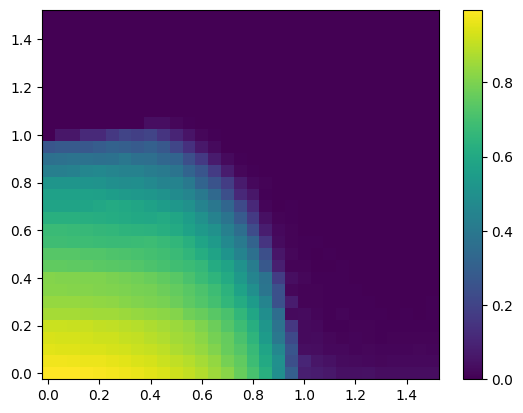

In [20]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


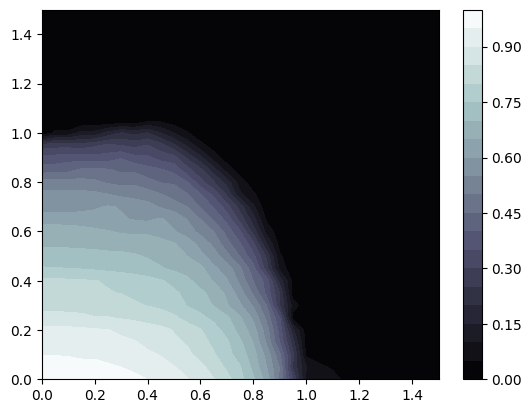

In [21]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


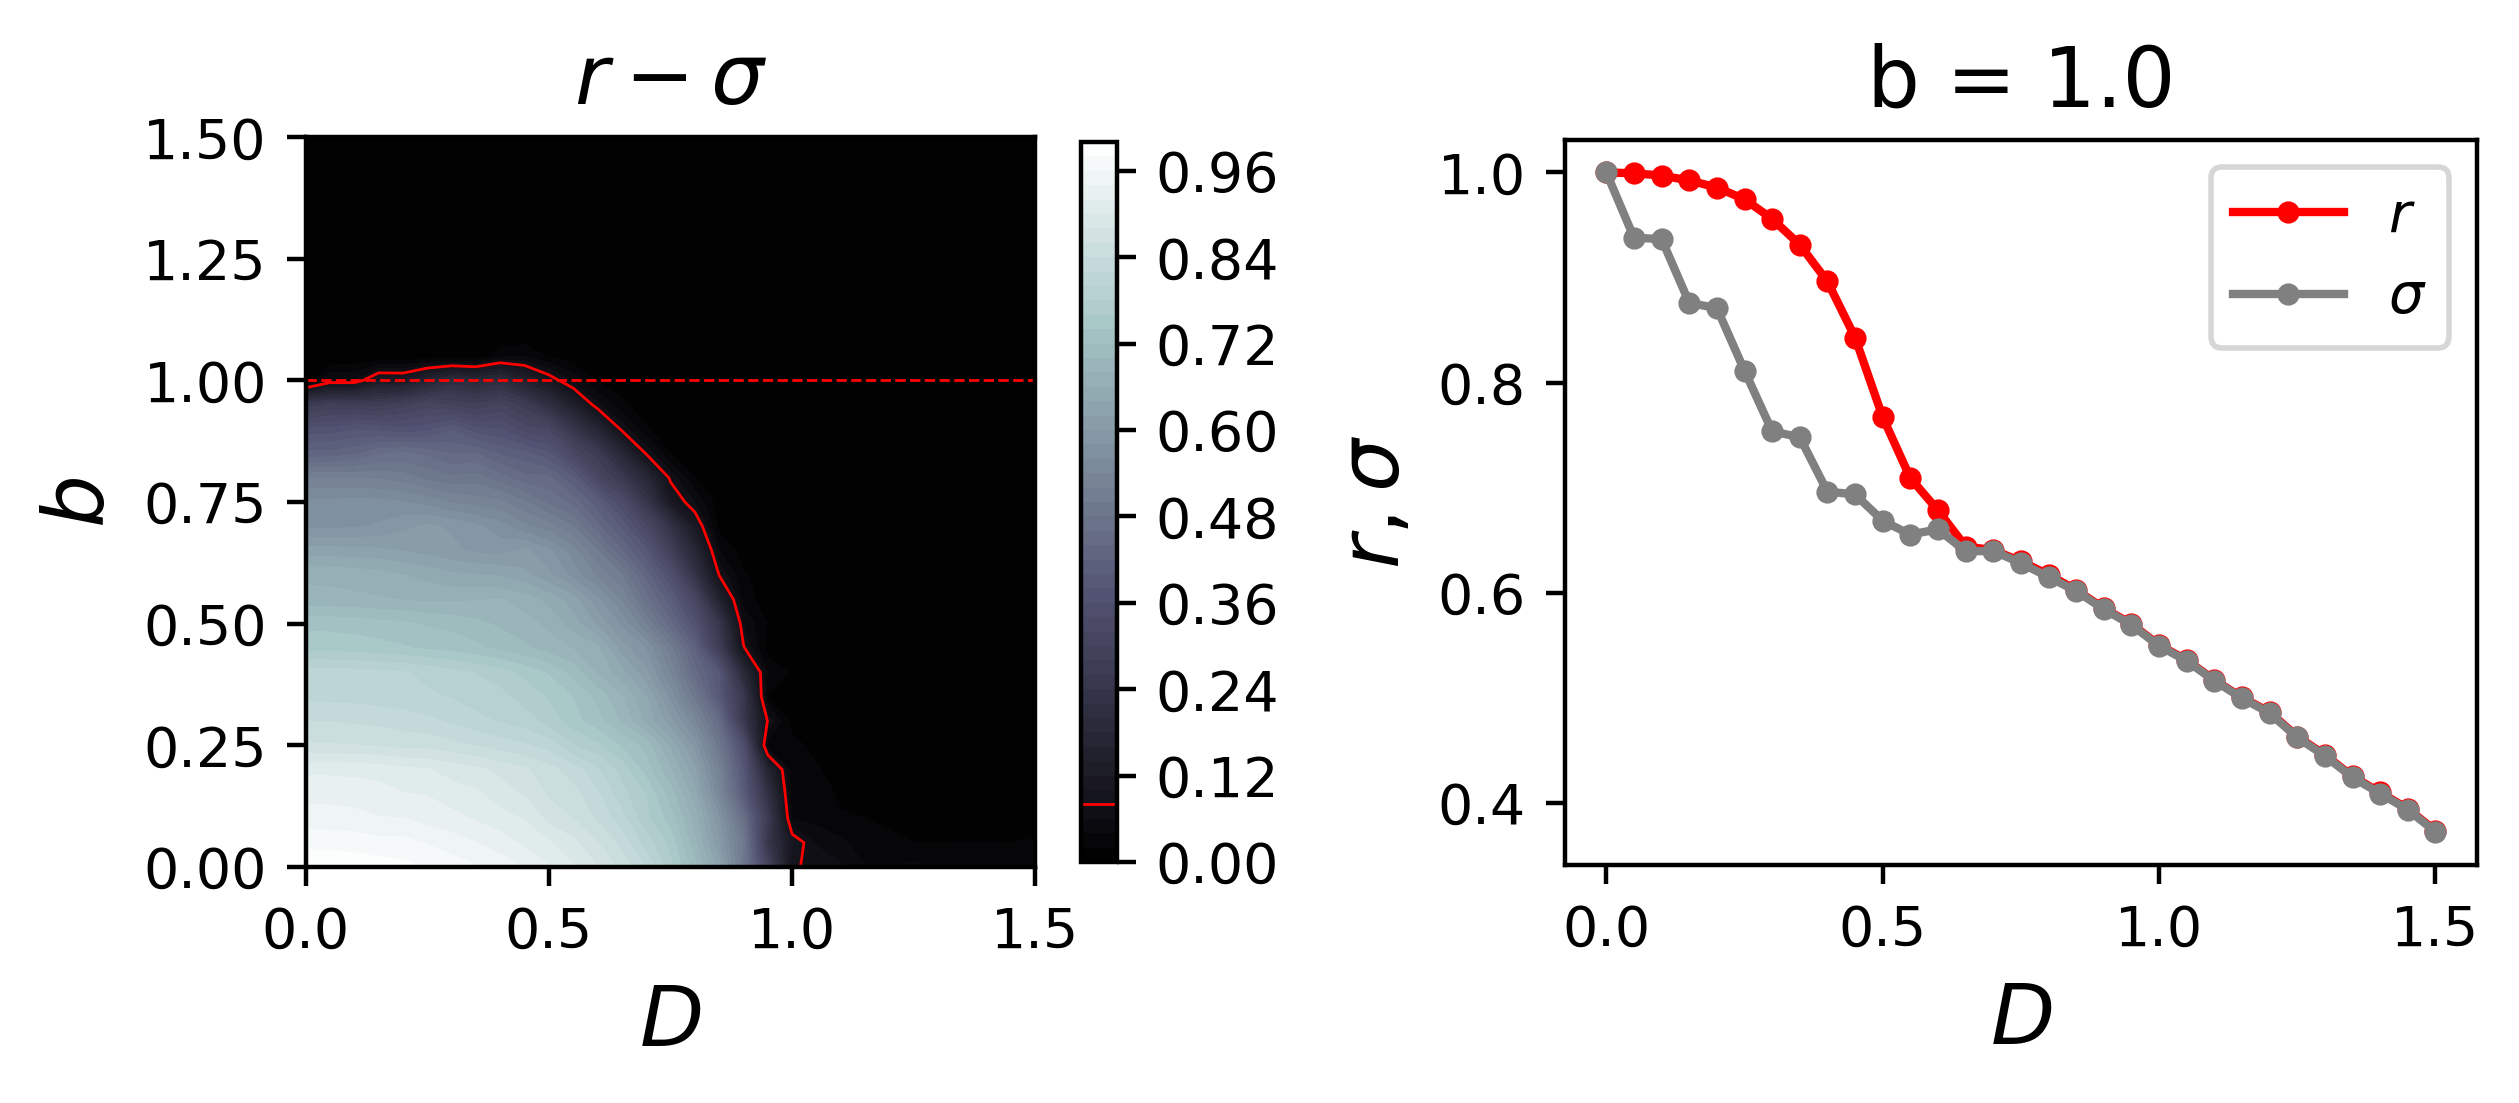

In [25]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 20
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[4:5],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()